In [2]:
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import random

# Setting seeds for reproducibility.
SEED = 42
keras.utils.set_random_seed(SEED)

This implementation covers (MAE refers to Masked Autoencoder):

- The masking algorithm
- MAE encoder
- MAE decoder
- Evaluation with linear probing

These are from the original paper

In [3]:
BUFFER_SIZE = 1024
BATCH_SIZE = 10
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (340, 500, 2)
NUM_CLASSES = 10

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 100

# AUGMENTATION
IMAGE_SIZE =   (340,500)
PATCH_SIZE = (34,50)  # Size of the patches to be extracted from the input images.
NUM_PATCHES = 100
MASK_PROPORTION = 0.60  # We have found 75% masking to give us the best results.

# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
ENC_LAYERS = 3
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2  # The decoder is lightweight but should be reasonably deep for reconstruction.
)
DEC_LAYERS = 1
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

data

# data util

In [4]:
# data util

def center_crop(img, dim):
    """
    cropping img
    """
    width, height = img.shape[1], img.shape[0]
    # process crop width and height for max available dimension
    crop_width = dim[0] if dim[0] < img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1] < img.shape[0] else img.shape[0]
    mid_x, mid_y = int(width / 2), int(height / 2)
    cw2, ch2 = int(crop_width / 2), int(crop_height / 2)
    crop_img = img[mid_y - ch2 : mid_y + ch2, mid_x - cw2 : mid_x + cw2]
    return crop_img

In [5]:
train = np.load('../data/processed/train_zm_jsd.npy',allow_pickle=True)
train = np.array([center_crop(im, [500,340]) for im in train if (im.shape[0]>=340 and im.shape[1]>=500)])
#train = np.stack((train[:,:,:,0],train[:,:,:,1],train[:,:,:,1]),axis=-1)

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices(train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

2023-04-16 17:25:50.378662: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-16 17:25:50.378815: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



Data augmentation:

Normally, in self-supervised things, augmentation plays an enoumes role. It does not for mae.

They therefore use a simple agumentation:
- resizing
- random cropping (fixed-size or random sized)
- random horizontal flipping


In [7]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [
        layers.Resizing(340, 500),],
        name="test_data_augmentation",
    )
    return model



exctract patches from images:

we take an entire image an extract patched. 

- show_patched_image -- Takes a batch of images and its corresponding patches to plot a random pair of image and patches.
- reconstruct_from_patch -- Takes a single instance of patches and stitches them together into the original image.

In [8]:
INPUT_SHAPE

(340, 500, 2)

In [9]:
class Patches(layers.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        print(self.patch_size)
        # Assuming the image has three channels each patch would be
        # of size (patch_size, patch_size, 3).
        self.resize = layers.Reshape((-1, PATCH_SIZE[0] * PATCH_SIZE[1] * INPUT_SHAPE[2]))

    def call(self, images):
        # Create patches from the input images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size[0], self.patch_size[1], 1],
            strides=[1, self.patch_size[0], self.patch_size[1], 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        # Reshape the patches to (batch, num_patches, patch_area) and return it.
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        # This is a utility function which accepts a batch of images and its
        # corresponding patches and help visualize one image and its patches
        # side by side.
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(images[idx][:,:,1])
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size[0], self.patch_size[1], INPUT_SHAPE[2]))
            plt.imshow(patch_img[:,:,1])
            plt.axis("off")
        plt.show()

        # Return the index chosen to validate it outside the method.
        return idx

    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patch(self, patch):
        # This utility function takes patches from a *single* image and
        # reconstructs it back into the image. This is useful for the train
        # monitor callback.
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size[0], self.patch_size[1], INPUT_SHAPE[2]))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

In [10]:
# Get a batch of images.
image_batch = next(iter(train_ds))

In [11]:
with tf.device('/cpu:0'):
    # Augment the images.
    augmentation_model = get_train_augmentation_model()
    augmented_images = augmentation_model(image_batch)

In [12]:
# Define the patch layer.
patch_layer = Patches()
# Get the patches from the batched images.
patches = patch_layer(images=augmented_images)


(34, 50)


Index selected: 6.


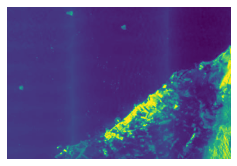

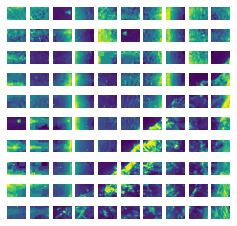

In [13]:
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)

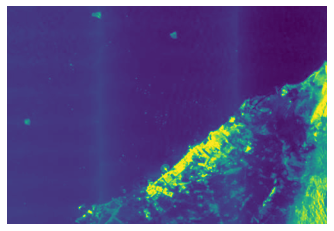

In [14]:



# Now pass the images and the corresponding patches
# to the `show_patched_image` method.


# Chose the same chose image and try reconstructing the patches
# into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image[:,:,1])
plt.axis("off")
plt.show()

## Patch encoding with masking
Quoting the paper

Following ViT, we divide an image into regular non-overlapping patches. Then we sample a subset of patches and mask (i.e., remove) the remaining ones. Our sampling strategy is straightforward: we sample random patches without replacement, following a uniform distribution. We simply refer to this as “random sampling”.


This layer includes masking and encoding the patches.

The utility methods of the layer are:

get_random_indices -- Provides the mask and unmask indices.
generate_masked_image -- Takes patches and unmask indices, results in a random masked image. This is an essential utility method for our training monitor callback (defined later).


In [15]:
class PatchEncoder(layers.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # This is a trainable mask token initialized randomly from a normal
        # distribution.
        self.mask_token = tf.Variable(
            tf.random.normal([1, self.patch_size[0] * self.patch_size[1] * INPUT_SHAPE[2]]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape
        print('number of patches ', self.num_patches)

        # Create the projection layer for the patches.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )

        # Number of patches that will be masked.
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        # Get the positional embeddings.
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)
        # Embed the patches.
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )  # (B, num_patches, projection_dim)

        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the patches that should be unmasked.
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)

            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            # Get the masked embeddings for the tokens.
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches),dtype=tf.float64), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        #mask_indices = tf.where(tf.less_equal(mask_indices, 0),0, mask_indices)

        unmask_indices = rand_indices[:, self.num_mask :]
        #unmask_indices = tf.where(tf.less_equal(unmask_indices, 0),0, unmask_indices)
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]
        # Build a numpy array of same shape as patch.
        new_patch = np.zeros_like(patch)

        # Iterate of the new_patch and plug the unmasked patches.
        count = 0

        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

In [16]:
# Create the patch encoder layer.
patch_encoder = PatchEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)
new_patch, random_index = patch_encoder.generate_masked_image(patches, unmask_indices)

number of patches  100


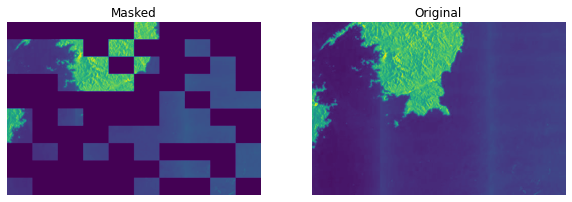

In [17]:
# Show a maksed patch image.

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow((img[:,:,1]))
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmented_images[random_index]
plt.imshow((img[:,:,1]))
plt.axis("off")
plt.title("Original")
plt.show()

# Model

In [18]:
def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

The MAE encoder is ViT. The only point to note here is that the encoder outputs a layer normalized output.

In [19]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    
    return keras.Model(inputs, outputs, name="mae_encoder")

# MAE decoder
The authors point out that they use an asymmetric autoencoder model. They use a lightweight decoder that takes "<10% computation per token vs. the encoder". We are not specific with the "<10% computation" in our implementation but have used a smaller decoder (both in terms of depth and projection dimensions).

In [20]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    print(image_size)
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])
    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units=34 * 50 * INPUT_SHAPE[2], activation="sigmoid")(x)
    x = layers.Reshape((34, 50, INPUT_SHAPE[2]))(x)
    outputs = tf.keras.layers.UpSampling2D(size=(10, 10))(x)

    #outputs = layers.Reshape((image_size[0] * image_size[1], 3))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")

In [21]:
train_augmentation_model = get_train_augmentation_model()

In [22]:
#test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()

(34, 50)


In [23]:
patch_encoder = PatchEncoder()

In [24]:
encoder = create_encoder()

In [25]:
encoder.summary()

Model: "mae_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 128)]  0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, None, 128)   256         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, None, 128)   263808      ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                        

In [26]:
decoder = create_decoder()

(340, 500)


In [27]:
decoder.layers[-1].output_shape

(None, 340, 500, 2)

In [276]:
import clearml
from clearml import Dataset
from clearml import Task

In [134]:

task = Task.create(project_name="RFI_mae", task_name=f"test1")

In [28]:
class MaskedAutoencoder2(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def call(self,inputs):
        encoded = self.encoder(inputs)
        return self.decoder(encoded)

    def calculate_loss(self, images, test=False):
        # Augment the input images.
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        # Patch the augmented images.
        patches = self.patch_layer(augmented_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compiled_loss(loss_patch, loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Apply gradients.
        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)

        # Update the trackers.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

In [29]:
import tensorflow as tf



class MaskedAutoencoder(tf.keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        test=False,
        images,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

    def calculate_loss(self, images, test=False):
        # Augment the input images.
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        # Patch the augmented images.
        patches = self.patch_layer(augmented_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        print(unmasked_embeddings.shape)
        self.unmasked_embeddings = unmasked_embeddings
        encoder_outputs = self.encoder(unmasked_embeddings)
        
        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        self.decoder_inputs = decoder_inputs
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        
        

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compiled_loss(loss_patch, loss_output)

        return total_loss, loss_patch, loss_output

    def call(self, inputs, training=None):
        if training:
            return self.train_step(inputs)
        else:
            return self.test_step(inputs)

    def build(self, input_shape):
        self.train_augmentation_model.build(input_shape)
        self.test_augmentation_model.build(input_shape)
        self.patch_layer.build(self.train_augmentation_model.compute_output_shape(input_shape))
        self.patch_encoder.build(self.patch_layer.compute_output_shape(self.train_augmentation_model.compute_output_shape(input_shape)))

        self.decoder  = self.decoder.build(self.decoder_inputs)
        self.encoder  = self.encoder.build(self.unmasked_embeddings)


    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Apply gradients.
        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        #total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)
        total_loss, loss_patch, loss_output = self(images, test=True)

        # Update the trackers.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}
    




SyntaxError: non-default argument follows default argument (2177514725.py, line 16)

In [30]:
import tensorflow as tf



class MaskedAutoencoder(tf.keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs, training=None, mask=None):
        # Augment the input images.
        if training:
            augmented_images = self.train_augmentation_model(inputs)
        else:
            augmented_images = self.test_augmentation_model(inputs)

        # Patch the augmented images.
        patches = self.patch_layer(augmented_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compiled_loss(loss_patch, loss_output)

        # Update metrics.
        self.compiled_metrics.update_state(loss_patch, loss_output)

        return total_loss



        #ae = tf.keras.models.Model(ae_input, ae_decoder_output, name=name)
        





    def calculate_loss(self, images, test=False):
        # Augment the input images.
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        # Patch the augmented images.
        patches = self.patch_layer(augmented_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compiled_loss(loss_patch, loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Apply gradients.
        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        #total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)
        total_loss, loss_patch, loss_output = self(images, test=True)

        # Update the trackers.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}
    




In [31]:
mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=train_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

In [32]:
#mae_model.build(input_shape=(None,340,500,2)) 
optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01)
# Compile and pretrain the model.

#example_input = tf.zeros((1, 340,500,2))
#mae_model.build(input_shape=example_input.shape)


mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)

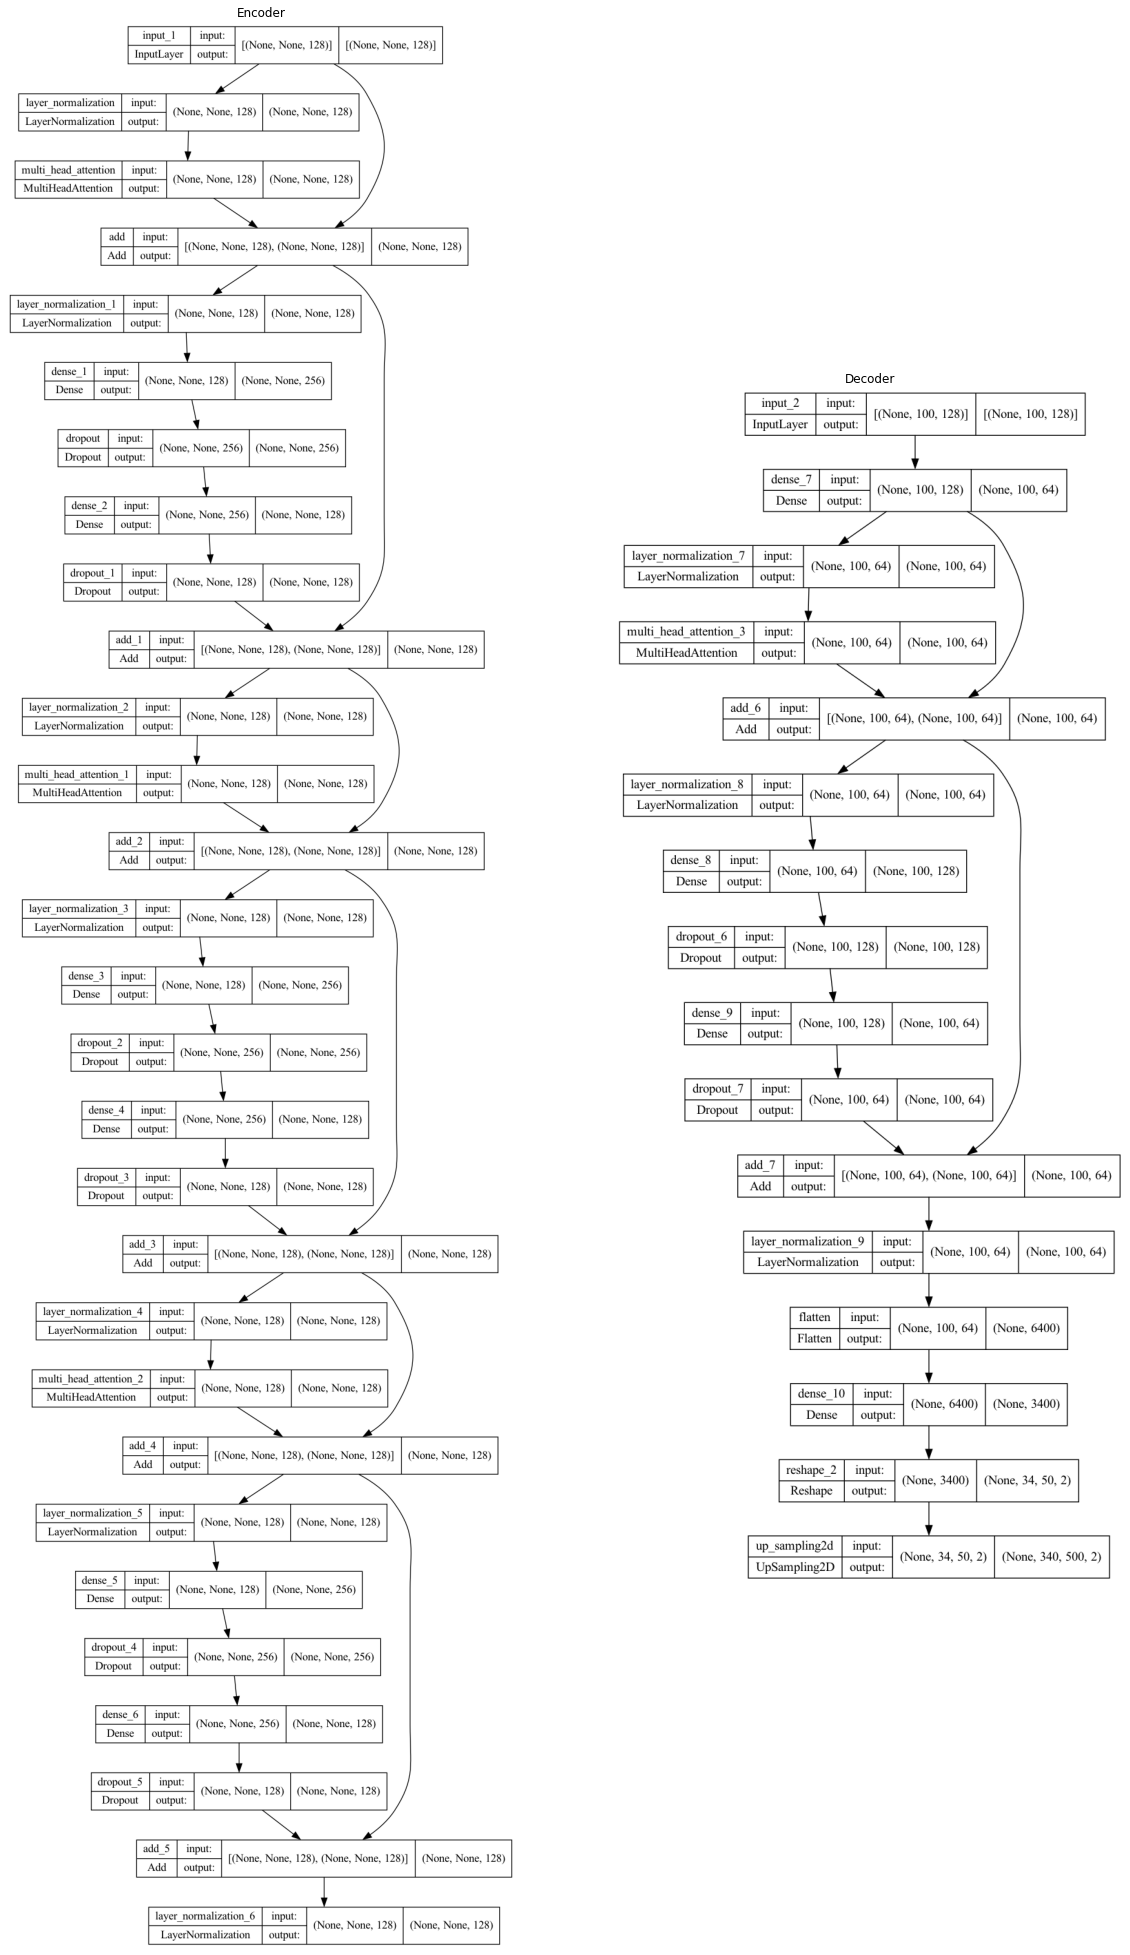

In [34]:
keras.utils.plot_model(encoder, show_shapes=True, to_file="encoder.png")
keras.utils.plot_model(decoder, show_shapes=True, to_file="decoder.png")
fig, ax = plt.subplots(1, 2, figsize=(20, 60))
ax[0].imshow(plt.imread('encoder.png'))
ax[0].set_title('Encoder', fontsize=12)
ax[0].axis("off")
ax[1].imshow(plt.imread('decoder.png'))
ax[1].set_title('Decoder', fontsize=12)
ax[1].axis("off");

In [33]:
mae_model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [399]:
mae_model.save_weights("ckpt")

In [404]:
mae_model.set_weights("ckpt")

ValueError: You called `set_weights(weights)` on layer "masked_autoencoder_15" with a weight list of length 4, but the layer was expecting 76 weights. Provided weights: ckpt...

In [403]:
history = mae_model.fit(
    train_ds, epochs=EPOCHS, validation_data=train_ds,
)

Epoch 1/100
102/102 [==============================] - ETA: 0s - loss: 0.0266 - mae: 0.1267

TypeError: in user code:

    File "/opt/homebrew/Caskroom/miniforge/base/envs/env_tf/lib/python3.9/site-packages/keras/engine/training.py", line 1525, in test_function  *
        return step_function(self, iterator)

    TypeError: tf__call() got an unexpected keyword argument 'test'


In [232]:
train_ds.take(10)

<TakeDataset element_spec=TensorSpec(shape=(None, 340, 500, 2), dtype=tf.float64, name=None)>

In [226]:
# Taking a batch of test inputs to measure model's progress.
test_images = next(iter(train_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            sim_vv = tf.image.ssim(original_image[:,:,0:1], reconstructed_image[:,:,0:1], 1.0)
            sim_vv = tf.image.ssim(original_image[:,:,1:], reconstructed_image[:,:,1:], 1.0)
            ssims = (sim_vv+sim_vv)/2
            print(f'\n{ssims}\n',tf.reduce_mean(tf.image.ssim(original_image, reconstructed_image, 1.0)))
            
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image[:,:,1])
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image[:,:,1])
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image[:,:,1])
            ax[2].set_title(f"Resonstructed: {epoch:03d}")

            plt.show()
            plt.close()


            

In [227]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )



In [ ]:
total_steps = int((len(train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()


In [235]:
scheduled_lrs = WarmUpCosine(
    learning_rate_base=0.0001,
    total_steps=1000,
    warmup_learning_rate=0.0,
    warmup_steps=10,
)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.298153e-06>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6.596306e-06>,
 <tf.Tensor: shape=(), dtype=float32, numpy=9.894458e-06>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.3192612e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.6490765e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.9788917e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.308707e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.6385223e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.9683377e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.298153e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.627968e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.9577833e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.287599e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.617414e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.9472295e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.2770447e-05>

In [228]:


# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]

In [184]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [190]:
class ssim_loss_mine(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [208]:
def reconstruct_from_patchs(patch):

        num_patches = 100
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, 34, 50, 2))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

In [211]:
34*50*2

3400

In [239]:
lrs = [tf.cast(scheduled_lrs(step),dtype=tf.float64) for step in range(total_steps)]


In [246]:
scheduled_lrs

In [247]:
tf.cast(lrs[0],dtype=tf.float64)

<tf.Tensor: shape=(), dtype=float64, numpy=0.0>

In [286]:
train_ds

<PrefetchDataset element_spec=TensorSpec(shape=(None, 340, 500, 2), dtype=tf.float64, name=None)>

Epoch 1/100


2023-04-13 15:43:18.470043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - ETA: 0s - loss: 0.0049 - mae: 0.0444

2023-04-13 15:44:26.860640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Idx chosen: 6

0.5599750876426697
 tf.Tensor(0.55973744, shape=(), dtype=float32)


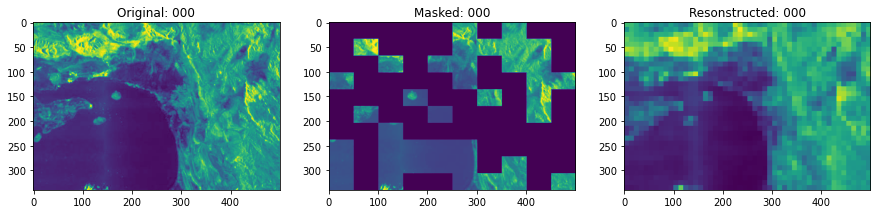

102/102 [==============================] - 93s 733ms/step - loss: 0.0049 - mae: 0.0444 - val_loss: 0.0048 - val_mae: 0.0442
Epoch 2/100
102/102 [==============================] - ETA: 0s - loss: 0.0049 - mae: 0.0447

KeyboardInterrupt: 

In [229]:
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)
# Compile and pretrain the model.
mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)
history = mae_model.fit(
    train_ds, epochs=EPOCHS, validation_data=train_ds, callbacks=train_callbacks,
)
# Measure its performance.
loss, mae = mae_model.evaluate(train_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")